# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
os.chdir(Path(os.path.abspath("")).parent)
from mros_data.datamodule import SleepEventDataModule
import matplotlib.pyplot as plt
import torch
import numpy as np
import ast

# Datamodule

The `SleepEventDataModule` class contains logic to iterate over event data by wrapping a `SleepEventDataset` class.
The datamodule is also responsible for splitting the data into train/eval partitions using the `setup()` method, and the user can then get a PyTorch `DataLoader` for each partition from the respective `*_dataloader()` methods.

## Instantiate class

We pass a dictionary of parameters to the datamodule class in order to instantiate it.
The only event-specific parameters of note are `events`, `default_event_window_duration`, `fs`, and `picks`, corresponding to the event code/event name, duration of default events, sampling frequency, and the specific channels to include.

Any transformations of the input data, such as short-time Fourier or continuous wavelet transforms can be included by the `transform` parameter.

In [3]:
'''from mros_data.datamodule.transforms import STFTTransform, morlet_transform, multitaper_transform
params = dict(
    data_dir="data/processed/mros/ar",
    batch_size=1,
    n_eval=2,
    n_test=2,
    num_workers=0,
    seed=1200,
    events={"ar": "Arousal", "lm": "Leg movement", "sdb": "Sleep-disordered breathing"},
    window_duration=600,  # seconds
    cache_data=True,
    default_event_window_duration=[15],
    event_buffer_duration=3,
    factor_overlap=2,
    fs=128,
    matching_overlap=0.5,
    n_jobs=-1,
    n_records=10,
    picks=["c3", "c4", "eogl", 'eogr', 'chin', 'legl', 'legr'],
    #transform = None,
    #transform = morlet_transform.MorletTransform(fs=128, fmin=0.5, fmax=35.0, nfft=1024),
    transform=STFTTransform(fs=128, segment_size=int(4.0 * 128), step_size=int(0.125 * 128), nfft=1024, normalize=True),
    #transform = multitaper_transform.MultitaperTransform(fs=128, fmin=0.5, fmax=35, tw=8.0, normalize=True),
    scaling="robust",
)

dm = SleepEventDataModule(**params)
#dm2 = SleepEventDataModule(**params2)'''
from mros_data.datamodule.transforms import STFTTransform

params = dict(
    data_dir="D:/10channel",
    batch_size=1,
    n_eval=1,
    n_test=1,
    num_workers=0,
    seed=1337,
    events={"ar": "arousals", "sdb": "Sleep-disordered breathing", "lm": "Leg Movement"},
    window_duration=600,  # seconds
    cache_data=True,
    default_event_window_duration=[15],
    event_buffer_duration=3,
    factor_overlap=2,
    fs=128,
    matching_overlap=0.5,
    n_jobs=-1,
    n_records=3,
    #picks=["c3", "c4"],
    picks=["c3", "c4", "eogl", 'eogr', 'chin', 'legl', 'legr', 'nasal', 'abdo', 'thor'],
    # transform=MultitaperTransform(128, 0.5, 35.0, tw=8.0, normalize=True),
    transform=STFTTransform(
        fs=128, segment_size=int(4.0 * 64), step_size=int(0.5 * 128), nfft=1024, normalize=True
    ),
    scaling="robust",
)
dm = SleepEventDataModule(**params)
print(dm)

SleepEventDataModule(data_dir=WindowsPath('D:/10channel'), n_test=1, n_eval=1, seed=1337, overfit=False, events={'ar': 'arousals', 'sdb': 'Sleep-disordered breathing', 'lm': 'Leg Movement'}, window_duration=600, cache_data=True, default_event_window_duration=[15], event_buffer_duration=3, factor_overlap=2, fs=128, matching_overlap=0.5, n_jobs=-1, n_records=3, picks=['c3', 'c4', 'eogl', 'eogr', 'chin', 'legl', 'legr', 'nasal', 'abdo', 'thor'], transform=<mros_data.datamodule.transforms.stft_transform.STFTTransform object at 0x000001729E49F820>, scaling='robust', batch_size=1, num_workers=0)


## Split dataset into train/eval partitions

In [4]:
from tqdm import tqdm

# The datamodule will split the dataset into train/eval partitions by calling the setup() method.
dm.setup('fit')
train_dl, eval_dl = dm.train_dataloader(), dm.val_dataloader()

# The dataloaders are generators, ie. we can iterate over them using a for-loop.
for i, (data, events, records, *_) in enumerate(train_dl):
    if i < 1:
        print(f'Batch size: {data.shape[0]} | No. channels: {data.shape[1]} | No. timepoints {data.shape[2]} | No. events: {sum([ev.shape[0] for ev in events])} | Data sample size: {list(data.shape[1:])} ')
    break


Using cache for data prep: C:\Users\Nullerh\Documents\DTU_SCHOOL_WORK\Semester7\sleep\data\.cache


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.86it/s]


Using cache for data prep: C:\Users\Nullerh\Documents\DTU_SCHOOL_WORK\Semester7\sleep\data\.cache


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


Batch size: 1 | No. channels: 10 | No. timepoints 513 | No. events: 6 | Data sample size: [10, 513, 1201] 


## Access the underlying datasets

The underlying data windows can be accessed by indexing into the dataset. This will call the `__getitem__()` method and yield the signals, and associated events. 
The events' start times and durations are normalized to the window, ie. an event with elements (0.1, 0.025) in a 10 min window will start at 10 min x 60 s / min x 0.1 = 60 s , and will last 10 min x 60 s / min x 0.025 = 15 s.

In [5]:
import numpy as np
train_ds = dm.train
no_event = 0
no_ar = 0
no_leg = 0
no_sdb = 0
#print(train_ds[0]['signal'].shape)
for idx, batch in enumerate(tqdm(train_ds)):
    #print(batch['events'])
    record = batch['record']
    data = batch['signal']
    events = batch['events']
    no_ar += list(events[:, -1]).count(0)
    no_leg += list(events[:, -1]).count(1)
    no_sdb += list(events[:, -1]).count(2)
    dur_ar = np
    break
print(no_sdb)
'''for idx, batch in enumerate(tqdm(train_ds2)):
    #print(batch['events'])
    record = batch['record']
    data2 = batch['signal']
    events = batch['events']
    print(data2.shape)
    break
#print(batch.keys())
#print(f'Record: {record} | No. channels: {data.shape[1]} | No. timepoints: {data.shape[2]} | No. events: {len(events)}')
assert(data.all() == data2.all())'''

  0%|                                                                                                                                                                                                          | 0/113 [00:00<?, ?it/s]

0


"for idx, batch in enumerate(tqdm(train_ds2)):\n    #print(batch['events'])\n    record = batch['record']\n    data2 = batch['signal']\n    events = batch['events']\n    print(data2.shape)\n    break\n#print(batch.keys())\n#print(f'Record: {record} | No. channels: {data.shape[1]} | No. timepoints: {data.shape[2]} | No. events: {len(events)}')\nassert(data.all() == data2.all())"

## Plotting signals

We can plot signals in the underlying dataset by using the `plot_signals()` method in the `SleepEventDataset`. Simply provide an index in the range `[0, len(dataset)]` and optionally a list of the applied channels:

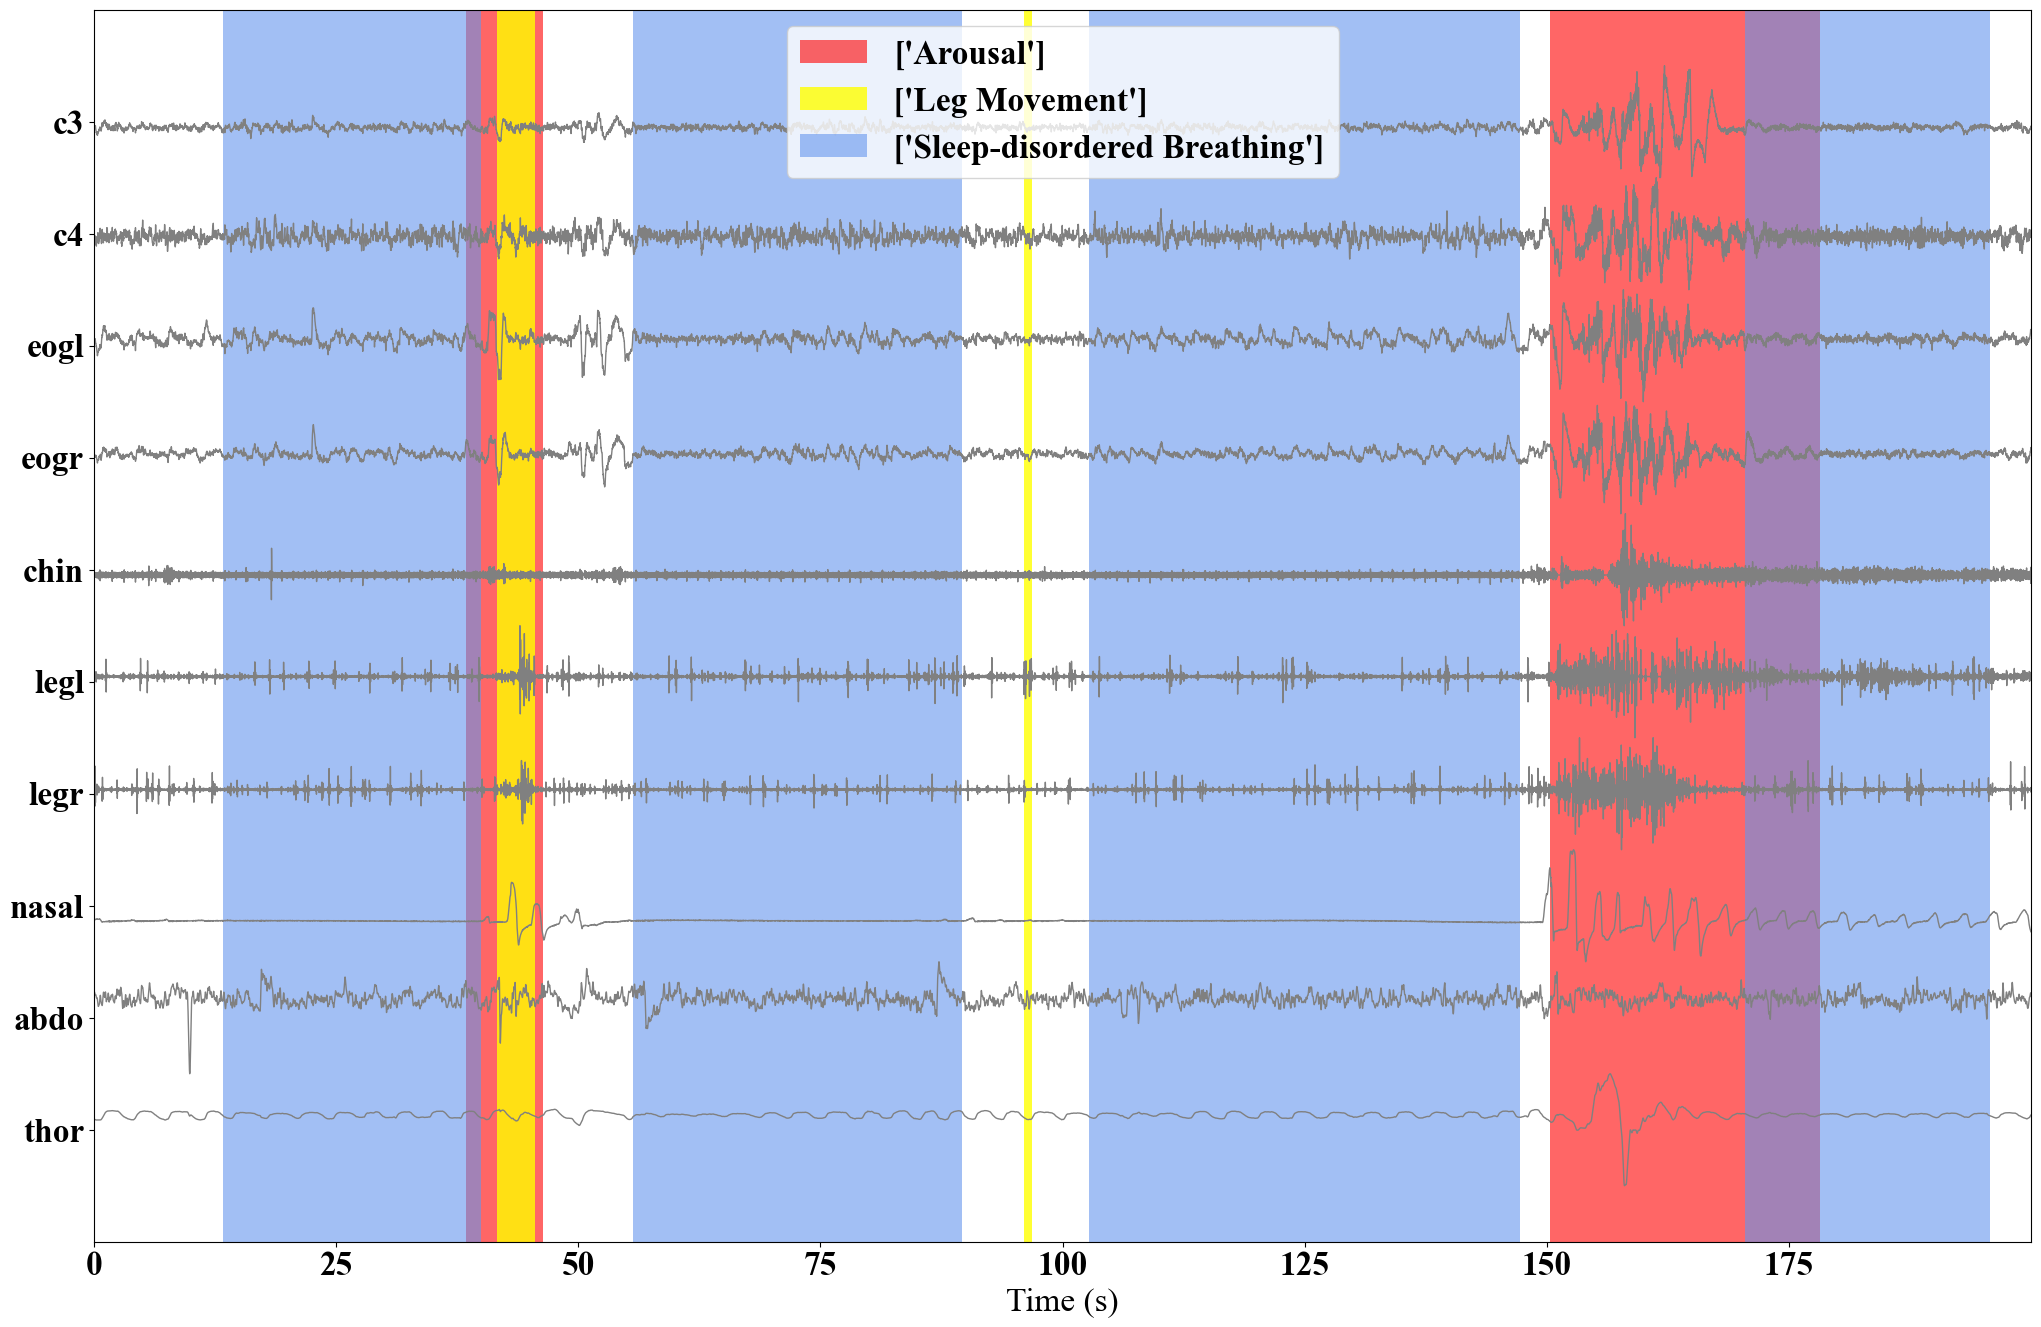

In [25]:
#train_ds2.plot_signals(idx, channel_names=['C3-A2', 'C4-A1', 'EOGL-A2', 'EOGR-A2', 'EMG']) #['Leg L', "Leg R"])
idx = 112
channels = ["c3", "c4", "eogl", 'eogr', 'chin', 'legl', 'legr', 'nasal', 'abdo', 'thor']
train_ds.plot_signals(idx, channel_names=channels) #['Leg L', "Leg R"])

## Transforming data on the fly

By using the `transform` argument in the `SleepEventDataModule`, we can get spectrograms of the data as well.

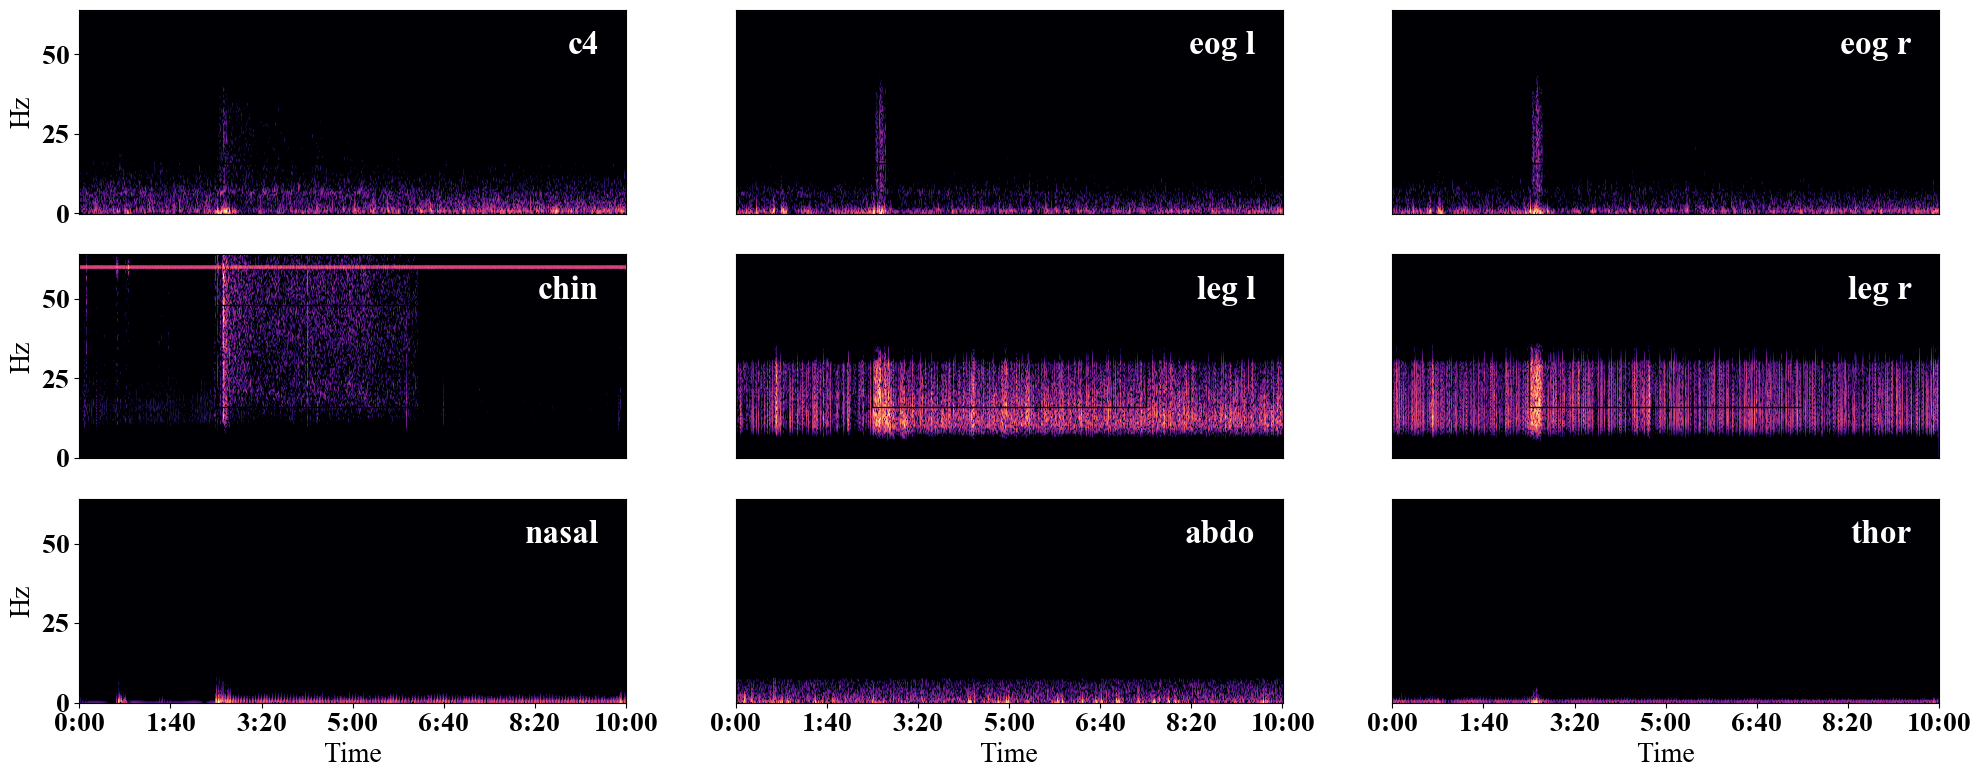

In [63]:
#    train_ds2.plot_spect(idx, channel_idx=channel_idx, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)
train_ds.plot_spect(idx, channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)


We can also combine the plots by using the `plot()` method:

In [ ]:
#%matplotlib widget
train_ds.plot(idx, channel_names=['C3-A2', 'C4-A1', 'EOGL-A2', 'EOGR-A2', 'EMG'], channel_idx=1, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)

## Experimentation

In [ ]:
for idx, batch in enumerate(train_ds):
    record = batch['record']
    data = batch['signal']
    events = batch['events']
    if len(events) > 5:
        break

In [ ]:
np.all(events[:,-1] == 1.0)

In [ ]:
COLORS = [
    [0.000, 0.447, 0.741], 
    [0.850, 0.325, 0.098], 
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556],
    [0.466, 0.674, 0.188],
    [0.301, 0.745, 0.933]  
] * 100
CLASSES = ['Ar', 'Lm', 'Sdb', 'N/A']
def get_box_coords(boxes):
    x, y, w, h = boxes.unbind(-1)
    x0, y0 = (x - 0.5 * w), (y - 0.5 * h)
    x1, y1 = (x + 0.5 * w), (y + 0.5 * h)
    box = [x0, y0, x1, y1]
    return torch.stack(box, dim=-1)

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def plot_results2(pil_img, prob, boxes, target, figsave):
    plt.figure(figsize=(12,6))
    plt.imshow(pil_img)
    ax = plt.gca()
    
    for prob, (x0, y0, x1, y1), color in zip(prob, boxes.tolist(),   COLORS * 100):
        if target:
            ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,  
             fill=False, color='mediumseagreen', linewidth=2))
            text = "Arousal"
            ax.text(x0, y0, text, fontsize=10,
                bbox=dict(facecolor='mediumseagreen', alpha=0.75))
        else:
            cl = prob.argmax()
            if prob[0] > 0.5:
                CLASSES[cl] = "Ar"
                ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,  
                 fill=False, color='mediumseagreen', linewidth=2))
                text = CLASSES[cl]
                ax.text(x0, y0, text, fontsize=10,
                    bbox=dict(facecolor='mediumseagreen', alpha=0.75))
            else:
                CLASSES[cl] = "Bc"
                ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,  
                 fill=False, color='gray', linewidth=2))
                text = CLASSES[cl]
                ax.text(x0, y0, text, fontsize=10,
                    bbox=dict(facecolor='gray', alpha=0.75))
    plt.axis('off')
    plt.savefig(figsave, dpi = 100)
    plt.show()

def scale_boxes(output_box, width, height):
    box_coords = get_box_coords(output_box)
    scale_tensor = torch.Tensor(
                 [width, height, width, height])
    return box_coords * scale_tensor

In [ ]:
path = "C:/Users/Nullerh/Desktop/1subject_multiclass/"
samples = torch.load(path + '150_sample.pt', map_location = torch.device('cpu'))
tgt_boxes = torch.load(path + '150_tgt_boxes.pt', map_location = torch.device('cpu'))
pred_boxes = torch.load(path + '150_pred_boxes.pt', map_location = torch.device('cpu'))
pred_logits = torch.load(path + '150_pred_logits.pt', map_location = torch.device('cpu'))

width = samples.shape[3]
height = samples.shape[2]
sidx = 6
pred_boxes = scale_boxes(pred_boxes, width, height)
tgt_boxes = scale_boxes(tgt_boxes[sidx]['boxes'], width, height)
#pred_logits = torch.nn.functional.softmax(pred_logits, dim=-1)

In [ ]:
cidx = 0
print(samples.shape, pred_logits.shape, pred_boxes.shape, tgt_boxes.shape)
img = samples[sidx][cidx].detach().cpu().numpy()

plot_results(img, pred_logits[sidx],  pred_boxes[sidx])

#plot_results(np.fliplr(np.flip(img)), pred_logits[sidx],  pred_boxes[sidx], target = False, figsave ="pred_150.png")
#plot_results(np.fliplr(np.flip(img)), pred_logits[sidx],  tgt_boxes, target = True, figsave = "tgt_150.png")

In [ ]:
lines = None
path = "C:/Users/Nullerh/Desktop/sleep_results/lastrun/"
losses = []
test_losses = []
with open(path + 'log.txt') as f:
    lines = f.readlines()

In [ ]:
for line in lines:
    print(ast.literal_eval(line).keys())
    losses.append(ast.literal_eval(line)['train_loss_ce'])
    test_losses.append(ast.literal_eval(line)['test_loss_ce'])

In [ ]:
lengths = len(test_losses)
epochs = range(lengths)
plt.plot(epochs, losses, 'g', label='Training loss')
plt.plot(epochs, test_losses, 'b', label='validation loss')
plt.title('GIoU score')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_val.png', dpi=400)
plt.show()
